### Import libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
%matplotlib inline


### Customize 

In [5]:
# Section A: Provide details for simulation model

#Market return
market_return_mean = 0.10  
market_return_vol = 0.15   

# About interest rate
initial_rate = 0.03
rate_mean = 0.04
rate_speed = 0.15
rate_vol = 0.02

# Inflation details
inflation_mean = 0.025
inflation_vol = 0.01

# About credit spread
spread_mean = 0.02
spread_vol = 0.008

# Section B: Provide data on the investment

# Specify initial investment
my_investment=100000

# Specify investment horizon 
my_holding_period=60

# Specify number of simulations
my_iteration=1000       

# Specify the CSV file to save data 
my_simulations='0507 portfolio_simulation.csv'

### Prepare the computational module 

In [6]:
class MonteCarloInvestmentSimulator:
    def __init__(self, initial_investment, time_periods, num_simulations):
        self.initial_investment = initial_investment
        self.time_periods = time_periods
        self.num_simulations = num_simulations
        
    def simulate_market_factors(self):
        market_returns = np.zeros((self.num_simulations, self.time_periods))
        interest_rates = np.zeros((self.num_simulations, self.time_periods))
        inflation_rates = np.zeros((self.num_simulations, self.time_periods))
        credit_spreads = np.zeros((self.num_simulations, self.time_periods))
        
        for sim in range(self.num_simulations):
            market_returns[sim] = np.random.normal(
                market_return_mean / 12, 
                market_return_vol / np.sqrt(12), 
                self.time_periods
            )
            
            rates = [initial_rate]
            for t in range(1, self.time_periods):
                dr = rate_speed * (rate_mean - rates[-1]) + rate_vol * np.random.normal(0, 1)
                rates.append(max(0.001, rates[-1] + dr))
            interest_rates[sim] = rates
            
            inflation_rates[sim] = np.random.normal(
                inflation_mean / 12, 
                inflation_vol / np.sqrt(12), 
                self.time_periods
            )
            
            spreads = [spread_mean]
            for t in range(1, self.time_periods):
                ds = 0.1 * (spread_mean - spreads[-1]) + spread_vol * np.random.normal(0, 1)
                spreads.append(max(0.001, spreads[-1] + ds))
            credit_spreads[sim] = spreads
            
        return market_returns, interest_rates, inflation_rates, credit_spreads
    
    def simulate_portfolio_returns(self, save_to_csv=True, filename=my_simulations):
        market_returns, interest_rates, inflation_rates, credit_spreads = self.simulate_market_factors()
        
        portfolio_values = np.zeros((self.num_simulations, self.time_periods + 1))
        portfolio_values[:, 0] = self.initial_investment

        for sim in range(self.num_simulations):
            for t in range(self.time_periods):
                total_return = (
                    market_returns[sim, t] -  
                    inflation_rates[sim, t] - 
                    credit_spreads[sim, t] +  
                    interest_rates[sim, t] / 12  
                )
                portfolio_values[sim, t + 1] = portfolio_values[sim, t] * (1 + total_return)

        if save_to_csv:
            # Create DataFrame to store all values
            columns = ["Simulation"]
            columns += [f"Month {i}" for i in range(self.time_periods + 1)]
            columns += [f"Rate_{i}" for i in range(self.time_periods)]
            columns += [f"Inflation_{i}" for i in range(self.time_periods)]
            columns += [f"Spread_{i}" for i in range(self.time_periods)]
            columns += [f"MarketReturn_{i}" for i in range(self.time_periods)]
            
            df_data = []
            for sim in range(self.num_simulations):
                row = [sim + 1]  # Simulation number
                row += list(portfolio_values[sim])  # Portfolio values
                row += list(interest_rates[sim])  # Interest rates
                row += list(inflation_rates[sim])  # Inflation rates
                row += list(credit_spreads[sim])  # Credit spreads
                row += list(market_returns[sim])  # Market returns
                df_data.append(row)

            df = pd.DataFrame(df_data, columns=columns)
            df.to_csv(filename, index=False)
            print(f"Simulation results saved to {filename}")

        return portfolio_values
    
    def calculate_risk_metrics(self, portfolio_values):
        final_values = portfolio_values[:, -1]
        returns = (final_values - self.initial_investment) / self.initial_investment
        
        metrics = {
            'Mean Final Value': np.mean(final_values),
            'VaR (95%)': np.percentile(final_values, 5),
            'Success Rate': np.mean(final_values > self.initial_investment) * 100,
            'Maximum Drawdown': np.min(portfolio_values / np.maximum.accumulate(portfolio_values, axis=1) - 1)
        }
        
        return metrics
    
    def display_metrics(self, metrics):
        print("\nKey Risk Metrics:")
        for key, value in metrics.items():
            if key == 'Success Rate':
                print(f"{key}: {value:.2f}%")
            else:
                print(f"{key}: {value:,.2f}")

    def plot_simulations(self, portfolio_values, metrics):
        fig, axes = plt.subplots(2, 1, figsize=(15, 14))  # Create two subplots
        
        time_points = np.arange(self.time_periods + 1)
        
        # Monte Carlo Simulation: Investment Value Paths
        axes[0].plot(time_points, portfolio_values.T, alpha=0.1, color='blue')
        axes[0].plot(time_points, np.mean(portfolio_values, axis=0), 'r--', linewidth=2, label='Mean Path')
        axes[0].fill_between(time_points,
                             np.percentile(portfolio_values, 5, axis=0),
                             np.percentile(portfolio_values, 95, axis=0),
                             alpha=0.5, color='blue', label='90% Confidence Interval')
        axes[0].set_title('Monte Carlo Simulation: Investment Value Paths')
        axes[0].set_xlabel('Time (months)')
        axes[0].set_ylabel('Portfolio Value')
        axes[0].legend()
        
        # Distribution of Final Portfolio Values
        sns.histplot(portfolio_values[:, -1], kde=True, ax=axes[1])
        axes[1].axvline(self.initial_investment, color='r', linestyle='--', label='Initial Investment')
        axes[1].set_title('Distribution of Final Portfolio Values')
        axes[1].set_xlabel('Final Portfolio Value')
        axes[1].set_ylabel('Frequency')
        axes[1].legend()
        
        # Adjust layout
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.12)  # Increases space at the bottom

        # Positioning the risk metrics at a more optimal location
        fig.text(0.12, 0.05, 
                 f"Mean Final Value: {metrics['Mean Final Value']:,.2f}\n"
                 f"VaR (95%): {metrics['VaR (95%)']:,.2f}\n"
                 f"Success Rate: {metrics['Success Rate']:.2f}%\n"
                 f"Maximum Drawdown: {metrics['Maximum Drawdown']:.2%}",
                 fontsize=12, bbox={"facecolor": "white", "alpha": 0.5, "pad": 5})
        plt.show()

### Load initial values for investment simulation 

In [7]:
# Usage
simulator = MonteCarloInvestmentSimulator(
    initial_investment=my_investment,  
    time_periods=my_holding_period,           
    num_simulations=my_iteration       
)

### Display simulation results 

Simulation results saved to 0507 portfolio_simulation.csv

Key Risk Metrics:
Mean Final Value: 48,562.14
VaR (95%): 16,935.43
Success Rate: 4.50%
Maximum Drawdown: -0.95


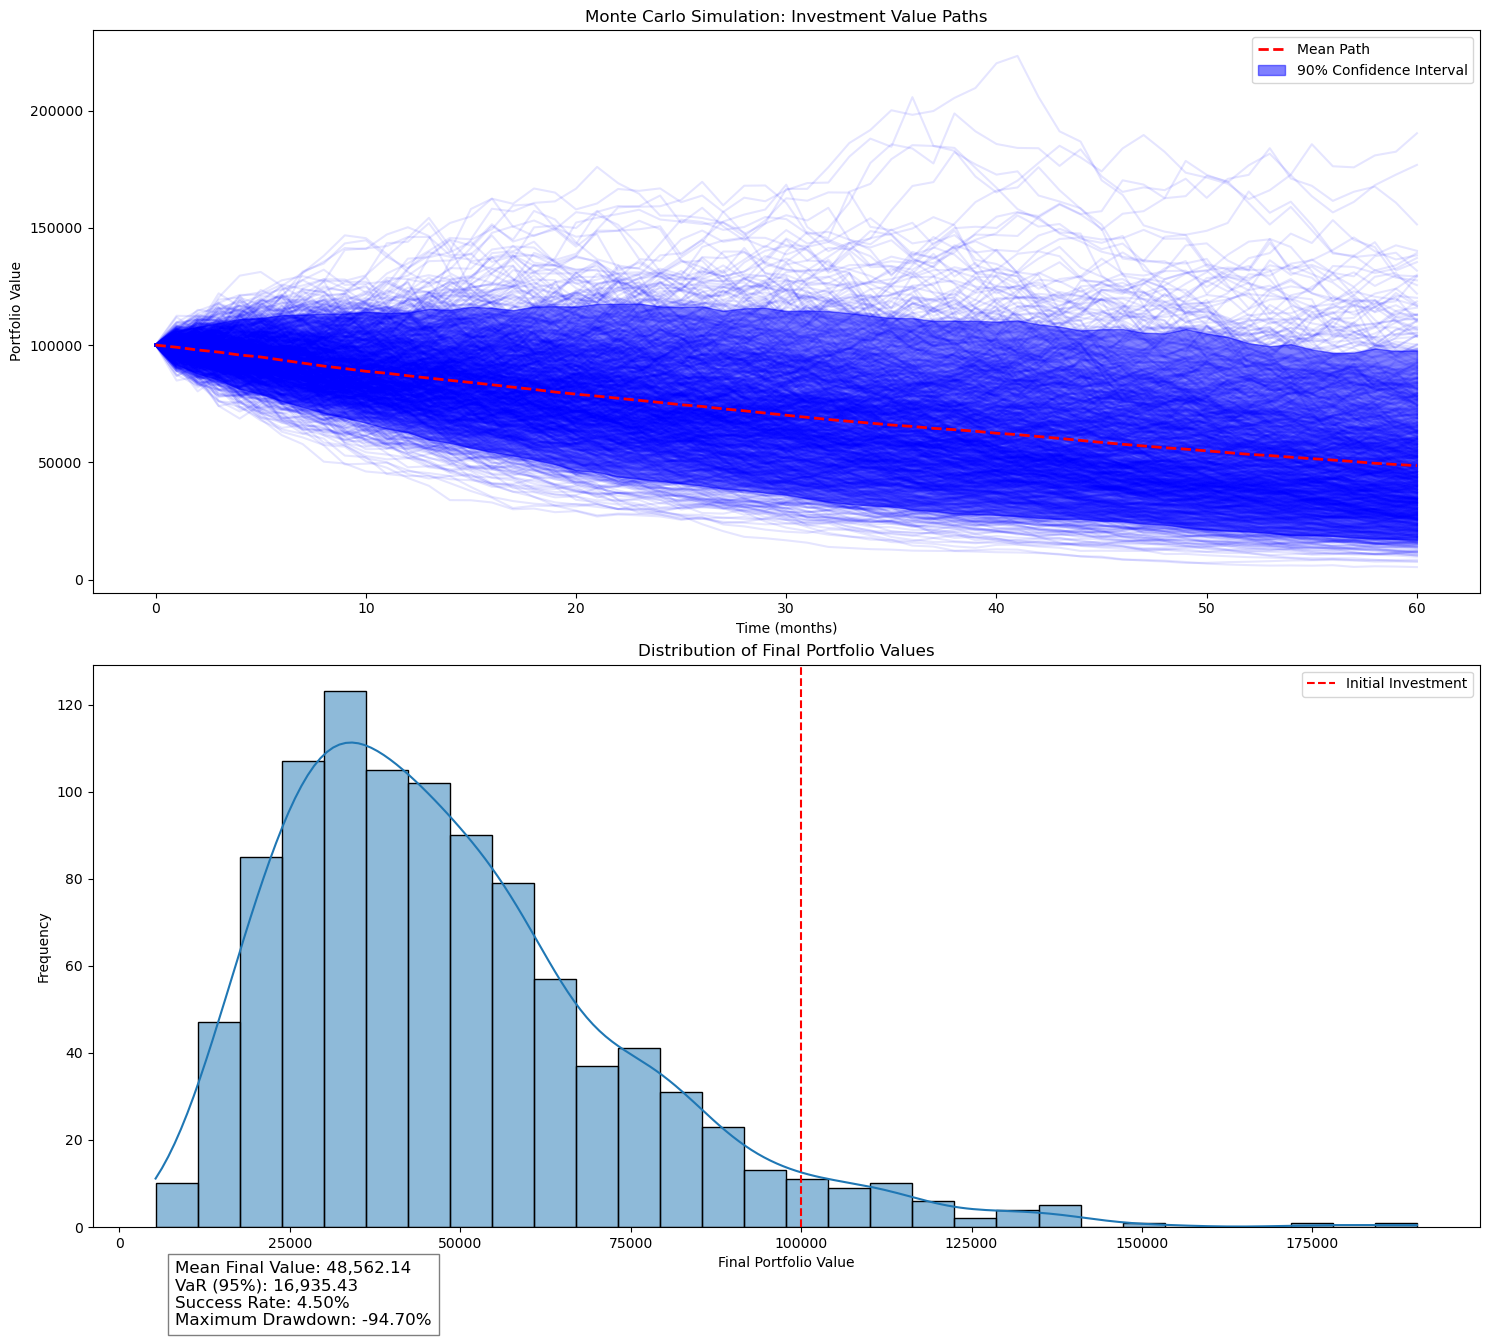

In [8]:
portfolio_values = simulator.simulate_portfolio_returns()
risk_metrics = simulator.calculate_risk_metrics(portfolio_values)
simulator.display_metrics(risk_metrics)
simulator.plot_simulations(portfolio_values, risk_metrics)